# Data analysis of credit activities

In [1]:
import os

from dotenv import load_dotenv
from pathlib import Path

import numpy as np
import pandas as pd
import sqlalchemy as sa

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [4]:
env_path = Path("src") / ".env"
load_dotenv(dotenv_path=env_path)
engine = sa.create_engine(os.getenv("DB_DSN_NOTEBOOK"))

with engine.connect() as conn:
    result = conn.execute(sa.text("SELECT version();"))
    print(result.fetchone())

('PostgreSQL 17.4 on x86_64-windows, compiled by msvc-19.43.34808, 64-bit',)


In [3]:
def execute_query(query):
    transaction_df = pd.read_sql(sql=query, con=engine, index_col='date', parse_dates='date')
    return transaction_df

In [4]:
query = f'SELECT a.id, a.name, b.card, c.date, c.amount, e.name as "category" \
        FROM public.card_holder a, public.credit_card b, public.transaction c, public.merchant d, public.merchant_category e \
        WHERE a.id = b.id_card_holder AND b.card=c.card AND c.id_merchant=d.id AND d.id_merchant_category=e.id'

transaction_df = execute_query(query)
transaction_df.head()

,id,name,card,amount,category
date,,,,,
2018-01-01 21:35:10,13,John Martin,3561954487988605,6.22,food truck
2018-01-01 21:43:12,13,John Martin,5135837688671496,3.83,bar
2018-01-01 22:41:21,10,Matthew Gutierrez,213193946980303,9.61,food truck
2018-01-01 23:13:30,4,Danielle Green,4263694062533017,19.03,pub
2018-01-01 23:15:10,18,Malik Carlson,4498002758300,2.95,restaurant


In [5]:
transaction_df["amount"].describe()

count    3500.000000
mean       40.789129
std       202.042922
min         0.510000
25%         3.735000
50%        10.270000
75%        14.647500
max      2249.000000
Name: amount, dtype: float64

<Axes: xlabel='amount', ylabel='Density'>

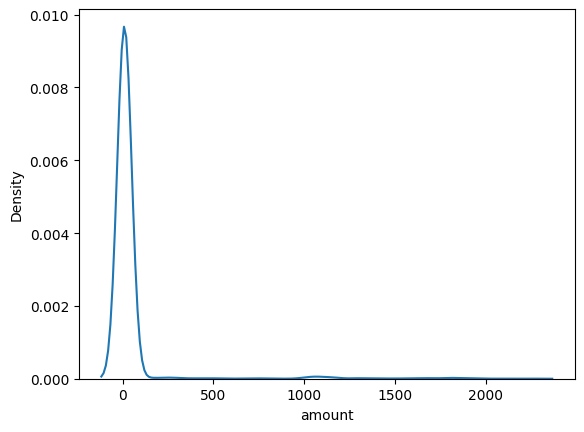

In [6]:
sns.kdeplot(transaction_df, x=transaction_df["amount"])

In [7]:
data_mean, data_std = np.mean(transaction_df["amount"]), np.std(transaction_df["amount"])

cut_off = 3 * data_std
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in transaction_df["amount"] if x<lower or x>upper] 
print(f"Outliers identfied {len(outliers)} out of {len(transaction_df['amount'])}")

transaction_df["outlier"] = (transaction_df["amount"] < lower) | (transaction_df["amount"] > upper)
transaction_df

Outliers identfied 77 out of 3500


,id,name,card,amount,category,outlier
date,,,,,,
2018-01-01 21:35:10,13,John Martin,3561954487988605,6.22,food truck,False
2018-01-01 21:43:12,13,John Martin,5135837688671496,3.83,bar,False
2018-01-01 22:41:21,10,Matthew Gutierrez,213193946980303,9.61,food truck,False
2018-01-01 23:13:30,4,Danielle Green,4263694062533017,19.03,pub,False
2018-01-01 23:15:10,18,Malik Carlson,4498002758300,2.95,restaurant,False
...,...,...,...,...,...,...
2018-12-31 01:24:15,15,Kyle Tucker,4723783028106084756,4.84,pub,False
2018-12-31 03:33:28,10,Matthew Gutierrez,4165305432349489280,3.26,restaurant,False
2018-12-31 05:53:58,19,Peter Mckay,5361779664174555,10.73,pub,False


In [8]:
outliers_transaction_df = transaction_df.copy()
outliers_transaction_df = outliers_transaction_df[outliers_transaction_df["outlier"]==True]

outliers_category_df = outliers_transaction_df["category"].value_counts()
outliers_name_df = outliers_transaction_df["name"].value_counts()

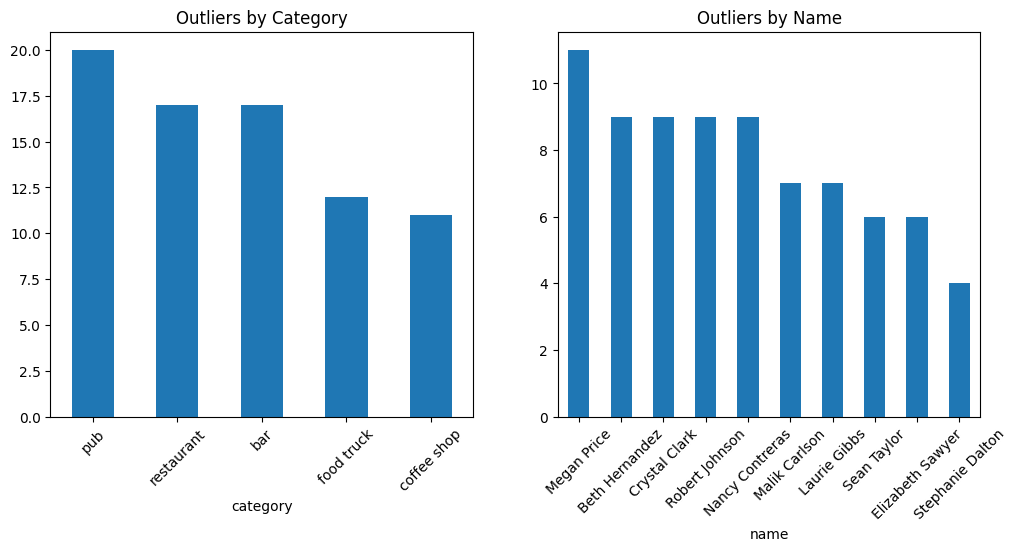

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
outliers_category_df.plot(kind='bar', ax=ax[0], title='Outliers by Category')
outliers_name_df.plot(kind='bar', ax=ax[1], title='Outliers by Name')

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)

In [10]:
import datetime 
start_time = datetime.time(0,0,0)
end_time = datetime.time(23,59,59)

transaction_anomalies = outliers_transaction_df.between_time(start_time=start_time, end_time=end_time).sort_values('amount', ascending=False)
px.scatter(transaction_anomalies, x='name', y='amount', color='category', title='Anomalous Transactions')

In [11]:
x = transaction_df[["amount"]]
y = transaction_df["outlier"].apply(lambda x: 1 if x==True else 0)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [12]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

RandomForestClassifier()

In [13]:
y_pred = classifier.predict(x_test)
print("Model accuracy: ", accuracy_score(y_test, y_pred))

Model accuracy:  1.0


In [ ]:
from skl2onnx import to_onnx

onnx_model = to_onnx(classifier, x[:1])

# Save the ONNX model to a file
with open("./ml-model/model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

['./ml-model/random_forest_model.pkl']